## LOAD DATA


In [250]:
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from pathlib import Path
import numpy as np
import seaborn as sns

idx = pd.IndexSlice

# pd.set_option('display.max_rows', 500)
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)

In [251]:
def process_df(df):
    record_df = pd.json_normalize(df['records'])
    # concatenate records data
    df = pd.concat([df, record_df],  axis=1)

    # drop original column
    df = df.drop('records', axis=1)

    # drop infractions columns

    # remove prefixes from column name
    df.columns = df.columns.str.removeprefix('meta.')
    df.columns = df.columns.str.removeprefix('scores.')
    df['driving_score'] = df['score_composed'] / 100
    df = df.rename(columns={"index": "route_index"})
    # change fps to str varaiable
    df['fps'] = df['fps'].astype(str)
    df = df.set_index(['rep', 'fps', 'highquality', 'route_index'])
    return df


def make_df(path: str):
    with open(path, "r") as f:

        p = Path(path)

        x = p.stem.split("_")
        data = {}
        data['fps'] = int(x[1])
        data['highquality'] = x[3]

        rep_no = [x[-1] for x in path.split('/') if 'rep' in x][0]
        data['rep'] = int(rep_no)
        content = json.load(f)
        data['records'] = content['_checkpoint']['records']

        df = pd.DataFrame(data)
        return process_df(df)

In [252]:
dfs = []
path = "data/ronin/rep*/*/*.json"
for file_path in glob.glob(path):
    # print(file_path)
    dfs.append(make_df(file_path))

df = pd.concat(dfs).sort_index()
df = df[['driving_score', 'duration_system']]

## FILTER DATA


### Filter duplicated scenarios

Filter scenarios that are exactly the same


In [253]:
# Routes of theese scenarios are duplicated
excluded_routes = [20, 21, 22, 23]
df = df.drop(excluded_routes, level='route_index', axis=0)

### Filter 16 FPS

Carla crashes at 16 so we need to filter this results out


In [254]:
# filter out 16 fps
df = df.drop("16", level='fps', axis=0)

In [255]:
df

driving_score  duration_system
rep fps highquality route_index                                
0   10  False       0                 0.026306       642.428658
                    1                 0.232490       536.358014
                    2                 0.113361       489.848481
                    3                 0.432466       277.129590
                    4                 0.168521       404.950006
...                                        ...              ...
9   20  True        127               1.000000       287.689000
                    128               1.000000       397.439014
                    129               1.000000       234.884112
                    130               0.600000       373.658720
                    131               0.965542       459.435260

[17920 rows x 2 columns]

## PROCESS DATA


### Driving score error


In [256]:
oracle_df = df.xs(("20", "True"), level=[
    'fps', 'highquality'], drop_level=False).sort_index()
oracle_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1280 entries, (0, '20', 'True', 0) to (9, '20', 'True', 131)
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   driving_score    1280 non-null   float64
 1   duration_system  1280 non-null   float64
dtypes: float64(2)
memory usage: 32.4+ KB


In [257]:

# oracle driving score per scenario
oracle_vec = oracle_df.groupby('route_index')['driving_score'].mean()
df['driving_score_error'] = (df['driving_score'] - oracle_vec).abs()

# df

## INVESTIGATE


### Labeling scenario safety


In [258]:
# consider only highquality rendering for now
data = df.xs("True", level='highquality')

# average the data across repetitions
data = data.groupby(['fps', 'route_index'])[
    'driving_score_error'].mean().to_frame()

In [259]:

safe_threshold = 0.01
risky_threshold = 0.25

data.loc[:, 'label'] = np.select(
    [data['driving_score_error'] < safe_threshold,
     data['driving_score_error'].between(safe_threshold, risky_threshold),
     data['driving_score_error'] > risky_threshold,
     ],
    ['safe', 'moderate', 'risky',],
)

In [260]:
def draw_dist(data):

    fig, (ax1,  ax2) = plt.subplots(1, 2, sharex=True)

    # fig.set_figheight(15)
    fig.set_figwidth(10)

    sns.histplot(
        data, x="fps", hue='label', hue_order=['risky', 'moderate', 'safe'], multiple="stack",  shrink=.8, ax=ax1
    )

    sns.stripplot(data, x='fps', y='driving_score_error', hue_order=['risky', 'moderate', 'safe'],
                  hue='label', ax=ax2)

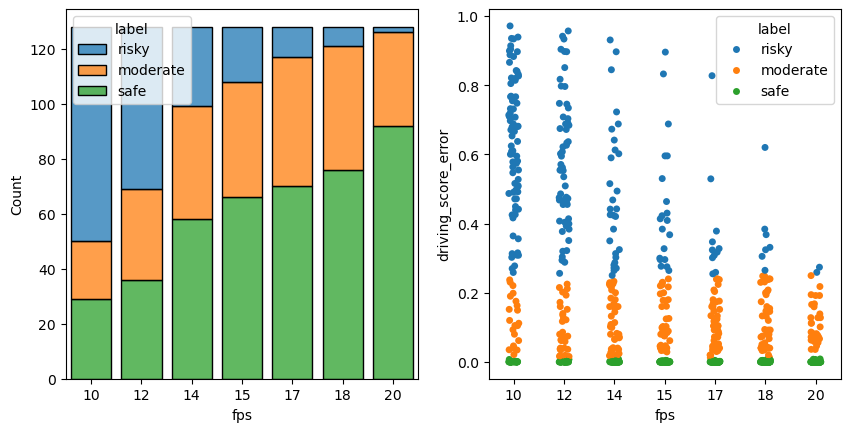

In [261]:
draw_dist(data)

### Keep only safe scenarios from highfidelity

Reduce flaky tests


In [262]:
highfid = data.xs("20")
safe_mask = highfid['label'] == 'safe'
# safe_mask
nonflakey = data.where(safe_mask).dropna()

In [263]:
nonflakey.groupby('fps').count()

,driving_score_error,label
fps,,
10,92,92
12,92,92
14,92,92
15,92,92
17,92,92
18,92,92
20,92,92


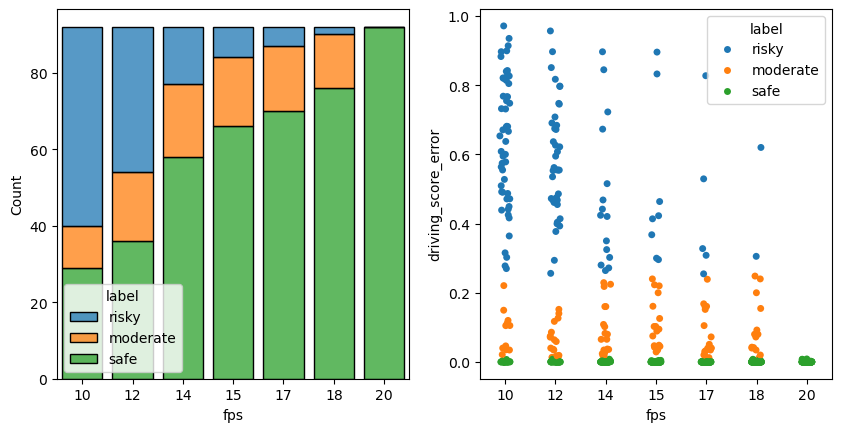

In [264]:

draw_dist(nonflakey)

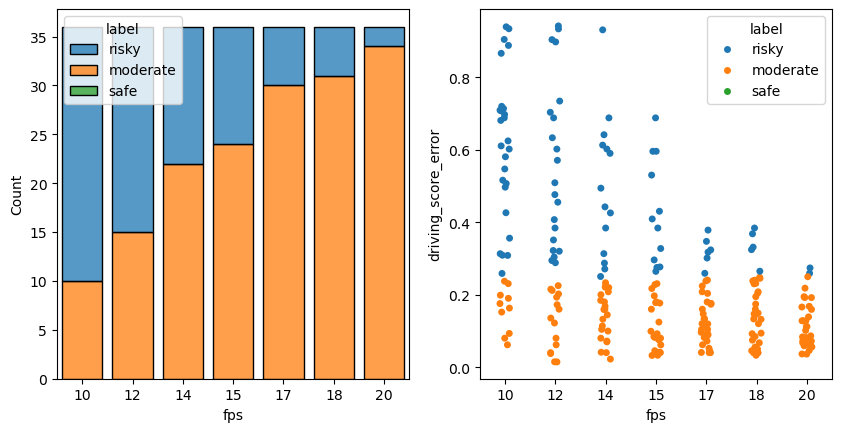

In [265]:
onlyflakey = data.where(~safe_mask).dropna()
draw_dist(onlyflakey)

### Flow chart


In [266]:
from itertools import product
from dataclasses import dataclass


@dataclass
class Transition:
    """Class for keeping track of an item in inventory."""
    source_fps: str
    source_label: str
    target_fps: str
    target_label: str
    value: int

    @property
    def source(self) -> str:
        return f"{self.source_fps} {self.source_label}"

    @property
    def target(self) -> str:
        return f"{self.target_fps} {self.target_label}"

    def __str__(self) -> str:
        return f'For {self.source_fps} {self.source_label} -> {self.target_fps} {self.target_label}: {self.value}'


transitions: list[Transition] = []

# reversing at the end
batches = list(data.groupby('fps'))[::-1]

# outer loop iterates over pairs of fps values (20, 18), (18, 17), (17, 15)...
for (source_fps, source_batch), (target_fps, target_batch) in zip(batches, batches[1:]):

    source_batches = list(source_batch.groupby('label'))
    target_batches = list(target_batch.groupby('label'))

    # inner loop iterates over pairs (safe, safe), (safe, moderate) ... to capture transitions
    for (source_label, source_label_batch),  (target_label, target_label_batch) in product(source_batches, target_batches):

        # merge batches with inner to calculate intersection between them
        merged = pd.merge(source_label_batch, target_label_batch,
                          how='inner', on=['route_index'])

        # size of merged is transition value
        value = merged.shape[0]
        t = Transition(source_fps, source_label,
                       target_fps, target_label, value)
        # print(t)
        transitions.append(t)

In [267]:
from itertools import cycle

figure_labels = [(t.source, t.target) for t in transitions]
figure_labels = {x for xs in figure_labels for x in xs}
figure_labels = list(figure_labels)
figure_labels = sorted(figure_labels, reverse=True)
fl_index_mapping = {fg: i for i, fg in enumerate(figure_labels)}
fl_index_mapping

colors = cycle(['rgb(0, 200, 0)', 'rgb(200, 0, 0)',  'rgb(0, 0, 200)'])
fl_color_mapping = dict(zip(figure_labels, colors))
fl_color_mapping.values()

dict_values(['rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)', 'rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)', 'rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)', 'rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)', 'rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)', 'rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)', 'rgb(0, 200, 0)', 'rgb(200, 0, 0)', 'rgb(0, 0, 200)'])

In [268]:
links = np.array([(fl_index_mapping[t.source], fl_index_mapping[t.target], t.value)
                  for t in transitions])
links = links.T
links

array([[ 2,  2,  2,  1,  1,  1,  0,  0,  0,  5,  5,  5,  4,  4,  4,  3,
         3,  3,  8,  8,  8,  7,  7,  7,  6,  6,  6, 11, 11, 11, 10, 10,
        10,  9,  9,  9, 14, 14, 14, 13, 13, 13, 12, 12, 12, 17, 17, 17,
        16, 16, 16, 15, 15, 15],
       [ 5,  4,  3,  5,  4,  3,  5,  4,  3,  8,  7,  6,  8,  7,  6,  8,
         7,  6, 11, 10,  9, 11, 10,  9, 11, 10,  9, 14, 13, 12, 14, 13,
        12, 14, 13, 12, 17, 16, 15, 17, 16, 15, 17, 16, 15, 20, 19, 18,
        20, 19, 18, 20, 19, 18],
       [31,  3,  0,  0,  2,  0, 14,  2, 76, 36,  6,  3,  3,  4,  0,  8,
         1, 67, 29, 11,  7,  4,  6,  1,  9,  3, 58, 28, 10,  4,  6, 14,
         0,  7,  5, 54, 23, 16,  2,  2, 26,  1,  8, 17, 33, 12, 16,  5,
         2, 57,  0,  7,  5, 24]])

In [269]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Sankey(
    arrangement='snap',
    node=dict(
        pad=15,
        thickness=10,
        line=dict(color="green", width=0.5),
        label=list(fl_index_mapping.keys()),
        customdata=list(fl_index_mapping.keys()),
        hovertemplate='%{customdata} has total value %{value}<extra></extra>',
        color=list(fl_color_mapping.values())
    ),
    link=dict(

        arrowlen=0,
        source=links[0],
        target=links[1],
        value=links[2],
        hovertemplate=' ',
    ))])

fig.update_layout(title_text="Basic Sankey Diagram", font_size=10)

## Safe scenarios


### Indexes of safe scenarios


### Inspect above scenarios manually
